# American-Sign-Language

Neste projeto, classificaremos os símbolos da língua gestual por meio da **Rede Neural Convolucional (CNN)**. Após o treinamento bem-sucedido do modelo CNN, o alfabeto correspondente de um símbolo de linguagem gestual será previsto. Avaliaremos o desempenho de classificação do nosso modelo usando as **matrizes de confusão** *normalizadas* e *não normalizadas*. Por fim, obteremos a pontuação de **precisão da classificação** do modelo CNN.

### Conjunto de dados

Usando o conjunto de dados *American Sign Language* (ASL) fornecido pelo MNIST, disponível publicamente no Kaggle, avaliamos modelos para classificar os gestos das mãos para cada letra do alfabeto. Devido ao movimento envolvido nas letras J e Z, essas letras não foram incluídas no conjunto de dados. 

Deste modo, este conjunto de dados contém 27455 imagens de treinamento e 7172 imagens de teste, todas com formato de 28x28 pixels com valores em tons de cinza entre 0-255. Essas imagens pertencem às 24 classes do alfabeto americano, começando de A a Y (excluindo as classes das letras J (9) e Z (25), como referido anteriormente).

O conjunto de dados no Kaggle está disponível no formato CSV, onde os dados de treinamento têm 27455 linhas e 785 colunas e os dados de teste têm 7172 linhas e 785 colunas. A primeira coluna do conjunto de dados representa o rótulo da classe da imagem e as 784 colunas restantes representam os 28x28 pixels.

<center><img src="images/american_sign_language.png" style="width:250px;height:150px;"></center>
<caption><center> Fig. 1: Alfabeto em língua gestual americana </center></caption>

### Tratamento e visualização dos dados

##### Importação de bibliotecas importantes

In [350]:
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import cv2

In [351]:
from sklearn.preprocessing import LabelBinarizer
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import img_to_array
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn import metrics

##### Leitura dos dados de treino e de teste dos ficheiros CSV

In [352]:
# obter os dados de treinamento
dataTrain = pd.read_csv('sign_mnist_train.csv')
# converter os rotulos dos dados de treinamento para uma matriz (rotulo)
yTrain = dataTrain['label'].values
# remover os rotulos dos dados de treinamento
dataTrain.drop('label', axis = 1, inplace = True)
# converter os dados de treinamento para uma matriz (rotulo + pixeis)
xTrain = dataTrain.values

# obter os dados de teste
dataTest = pd.read_csv('sign_mnist_test.csv')
# converter os rotulos dos dados de teste para uma matriz (rotulo)
yTest = dataTest['label'].values
# remover os rotulos dos dados de teste
dataTest.drop('label', axis = 1, inplace = True)
# converter os dados de teste para uma matriz (rotulo + pixeis)
xTest = dataTest.values
# verificar os dados de teste para verificar os rotulos de classe e as colunas que representam os pixeis
# dataTest.head()

##### Especificar os rótulos de classe para as imagens

In [353]:
class_name = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K' , 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X','Y')

##### Histograma com o número de vezes que aparece uma letra do alfabeto, onde "A" corresponde à classe 0, "B" à classe 1 e assim sucessivamente

([<matplotlib.axis.XTick at 0x297ae384c40>,
 [Text(0, 0, 'A'),
  Text(1, 0, 'B'),
  Text(2, 0, 'C'),
  Text(3, 0, 'D'),
  Text(4, 0, 'E'),
  Text(5, 0, 'F'),
  Text(6, 0, 'G'),
  Text(7, 0, 'H'),
  Text(8, 0, 'I'),
  Text(9, 0, 'K'),
  Text(10, 0, 'L'),
  Text(11, 0, 'M'),
  Text(12, 0, 'N'),
  Text(13, 0, 'O'),
  Text(14, 0, 'P'),
  Text(15, 0, 'Q'),
  Text(16, 0, 'R'),
  Text(17, 0, 'S'),
  Text(18, 0, 'T'),
  Text(19, 0, 'U'),
  Text(20, 0, 'V'),
  Text(21, 0, 'W'),
  Text(22, 0, 'X'),
  Text(23, 0, 'Y')])

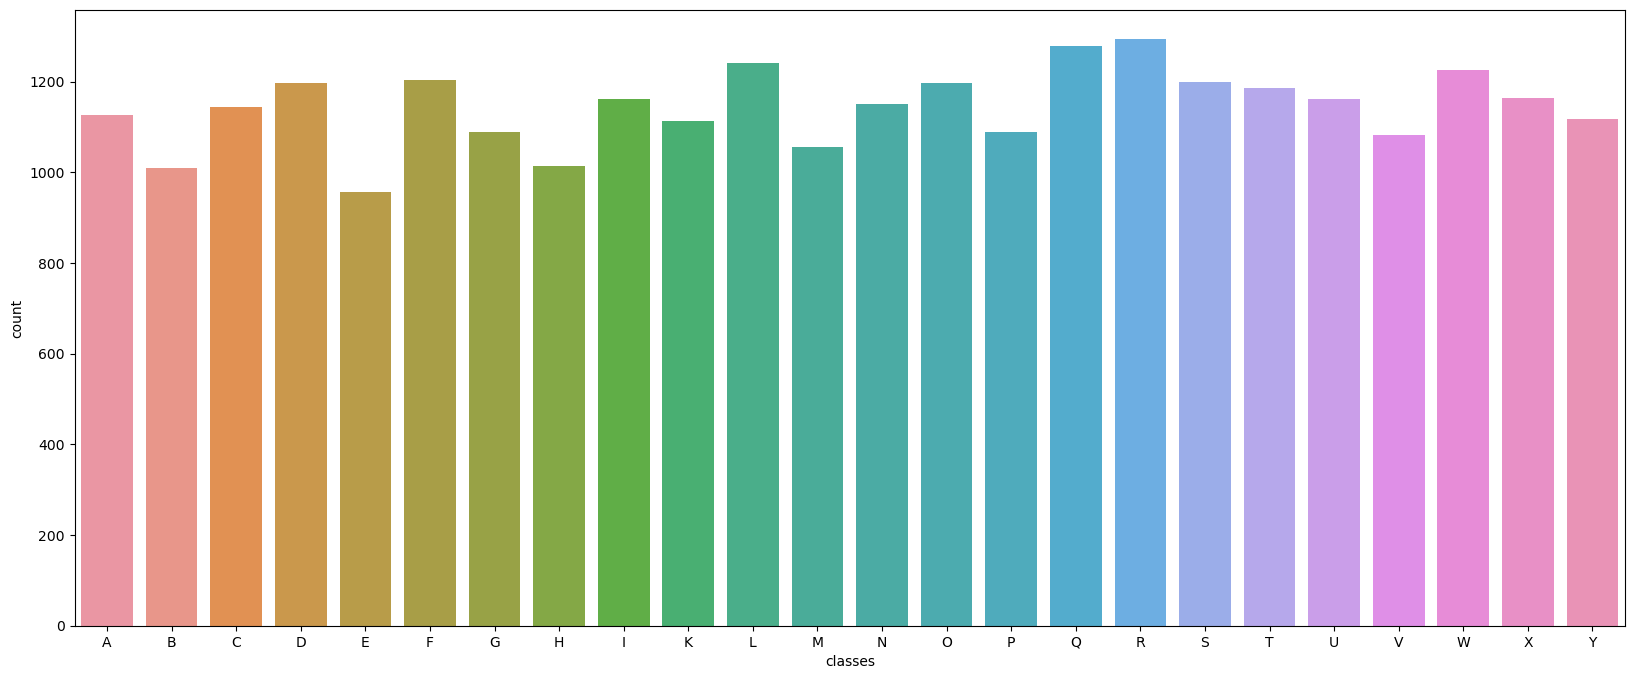

In [354]:
#plt.figure(figsize = (20,8))
#plt.xlabel('classes')
#sns.countplot(x = yTrain)

plt.figure(figsize = (20,8))
plt.xlabel('classes')
sns.countplot(x = yTrain)
x_pos = np.arange(len(class_name))
plt.xticks(x_pos, class_name)

##### Processar conjunto de dados para o treinamento

"-1" especifica que esta dimensão no eixo atual deve ser calculada dinamicamente de acordo com a regra de que os elementos totais do tensor permanecem inalterados.

In [355]:
xTrain = np.array(xTrain.reshape(-1,28,28,1))
xTest = np.array(xTest.reshape(-1,28,28,1))
print(xTrain.shape)
print(xTest.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


##### Converter os rótulos das classes em rótulos binários (onde "1" significa que pertence e "0" que não pertence à classe)

In [356]:
lbTrain = LabelBinarizer()
lbTest = LabelBinarizer()
yTrain = lbTrain.fit_transform(yTrain)
yTest = lbTest.fit_transform(yTest)

##### Visualizar algumas imagens do conjunto de dados de treinamento

Text(0.5, 0.98, 'Some images from train data set')

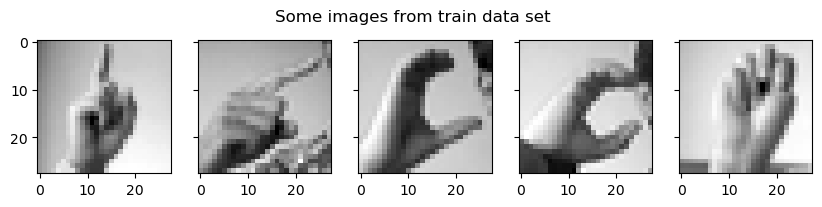

In [357]:
plt.style.use('_classic_test_patch')
fig, axs = plt.subplots(1, 5, figsize=(10, 2), sharey=True)
for i in range(5): 
    axs[i].imshow(xTrain[i].reshape(28,28),cmap='gray')
fig.suptitle('Some images from train data set')

### Conjunto de dados Definir o modelo CNN (Convolutional Neural Network)

A partir da definição da documentação tensorflow.keras, o modelo *Sequencial* é uma stack linear de camadas. O parâmetro *kernel_size* é um inteiro que especifica o mesmo valor para todas as dimensões espaciais, ou tuplo/lista de 2 inteiros, que especifica a altura e largura da janela de convolução 2D. O parâmetro *activation* é uma função de ativação a ser aplicada. O parâmetro *input_shape* é um tensor com a forma: batch_shape + (linhas, colunas, canais), quando data_format = 'canais_last', onde é preciso usar as dimensões da imagem de entrada.

A camada de entrada do modelo obterá imagens de tamanho (28,28,1) onde 28,28 são a altura e a largura da imagem, respetivamente, enquanto 1 representa o canal de cor da imagem para tons de cinza.
A camada de saída do modelo terá 24 neurónios para 24 letras diferentes, e a função de ativação será *softmax*, pois é um problema de classificação multiclasse.

A primeira camada oculta é composta por vários nós, cada um dos quais tem uma soma ponderada dos 784 valores de entrada. A soma ponderada das entradas é então inserida numa função de ativação ReLU (Rectified Linear Unit). o ReLU produzirá 0 quando a entrada for negativa, mas não mudará a entrada de outra forma. As saídas do ReLU servirão como entradas para a próxima camada oculta na rede.

À medida que os dados continuam a se mover pelas camadas ocultas, a rede neural tenta extrair mais recursos abstratos.

Depois que os dados passam pelas camadas Convolution (*Conv2D*) e MaxPool (*MaxPooling2D*) da rede neural, eles entram nas camadas *Flatten* e *Dense*. Essas camadas são responsáveis por reduzir os dados a uma dimensão e identificar a classe de uma imagem.

Observe que o Dropout foi definido como 0,2 no final. No backend, ele essencialmente reduz o overfitting, ou seja, o fenômeno quando o modelo tem um desempenho muito bom nos dados de treinamento, mas falha miseravelmente com os dados de teste.

Depois que a arquitetura da CNN foi definida, tentamos otimizar o desempenho do modelo selecionando um valor apropriado para o número de épocas. Anteriormente, mencionamos que cada nó obtém uma soma ponderada de suas entradas. Os pesos aplicados a cada entrada são aprendidos durante o processo de treinamento e atualizados a cada época. Uma época é uma única passagem por todos os dados de treinamento. Na primeira época, a rede neural estima um valor para cada peso. Para cada época subsequente, a rede neural atualiza esses pesos com valores que reduzem a perda geral. Geralmente, mais épocas resultam em classificadores mais precisos; no entanto, mais épocas também produzem modelos mais complexos. 

In [358]:
model = Sequential()
# camada de convolução 1
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

# camada de convolução 2
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

# camada de convolução 3
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(24, activation = 'softmax'))

##### Compilar o modelo de CNN (Convolutional Neural Network)

Depois do CNN pronto, é preciso treinar o modelo alimentando o conjunto de treinamento. Existem vários otimizadores que podem ser usados, mas foi escolhido o *adam*.

Depois que a arquitetura da CNN foi definida, tentamos otimizar o desempenho do modelo selecionando um valor apropriado para o número de épocas. 

Cada nó obtém uma soma ponderada de suas entradas. Os pesos aplicados a cada entrada são aprendidos durante o processo de treinamento e atualizados a cada epoch (época). Uma época é uma única passagem por todos os dados de treinamento. Na primeira época, a rede neural estima um valor para cada peso. Para cada época subsequente, a rede neural atualiza esses pesos com valores que reduzem a perda geral. 

Geralmente, mais épocas resultam em classificadores mais precisos; no entanto, mais épocas também produzem modelos mais complexos e levam mais tempo de treinamento.

In [359]:
model.compile(loss = tensorflow.keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.Adam(), metrics=['accuracy'])

##### Treinar o modelo CNN (Convolutional Neural Network)

In [360]:
history = model.fit(xTrain, yTrain, validation_data = (xTest, yTest), epochs=100, batch_size=128)

Epoch 1/100
215/215 [==============================] - 21s 93ms/step - loss: 4.5359 - accuracy: 0.0730 - val_loss: 2.6378 - val_accuracy: 0.2262
Epoch 2/100
215/215 [==============================] - 19s 90ms/step - loss: 2.4473 - accuracy: 0.2367 - val_loss: 1.5672 - val_accuracy: 0.5519
Epoch 3/100
215/215 [==============================] - 19s 88ms/step - loss: 1.6209 - accuracy: 0.4627 - val_loss: 1.0367 - val_accuracy: 0.6559
Epoch 4/100
215/215 [==============================] - 19s 90ms/step - loss: 1.1655 - accuracy: 0.6084 - val_loss: 0.7925 - val_accuracy: 0.7305
Epoch 5/100
215/215 [==============================] - 18s 82ms/step - loss: 0.8349 - accuracy: 0.7132 - val_loss: 0.7114 - val_accuracy: 0.7663
Epoch 6/100
215/215 [==============================] - 18s 83ms/step - loss: 0.6169 - accuracy: 0.7855 - val_loss: 0.4337 - val_accuracy: 0.8642
Epoch 7/100
215/215 [==============================] - 20s 92ms/step - loss: 0.4727 - accuracy: 0.8391 - val_loss: 0.3618 - val_ac

In [361]:
model.save('sign_language')
model.summary()
model = tensorflow.keras.models.load_model('sign_language')

INFO:tensorflow:Assets written to: sign_language\assets
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 64)          36928     
________________________________________________________________

##### Visualizar o desempenho do treinamento do modelo CNN

Depois do treinamento acabar, desenhou-se a variação de precisão com a época para visualizar como nosso modelo está melhorando a cada época.

Text(0.5, 1.0, 'Evolução de precisão (Accurary Evolution)')

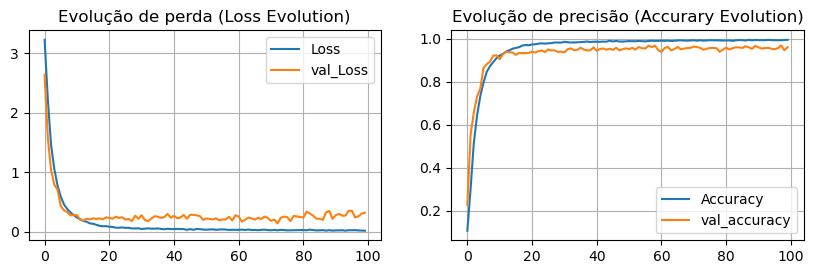

In [362]:
plt.style.use('default')
plt.figure(figsize = (10,6))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'val_Loss')
plt.legend()
plt.grid()
plt.title('Evolução de perda (Loss Evolution)')

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.grid()
plt.title('Evolução de precisão (Accurary Evolution)')

##### Usar o modelo CNN treinado para fazer previsões sobre os dados de teste invisíveis

In [364]:
predicted_classes = model.predict_classes (xTest)
pred2 = np.zeros(shape=(7172,))

for i in range(7172):
    if(predicted_classes[i]>=9):
        pred2[i] = predicted_classes[i] + 1
    else:
        pred2[i] = predicted_classes[i]
pred2 = pred2.astype(int)

##### Visualização das previsoes dos rótulos das classes para as imagens de teste do modelo da CNN

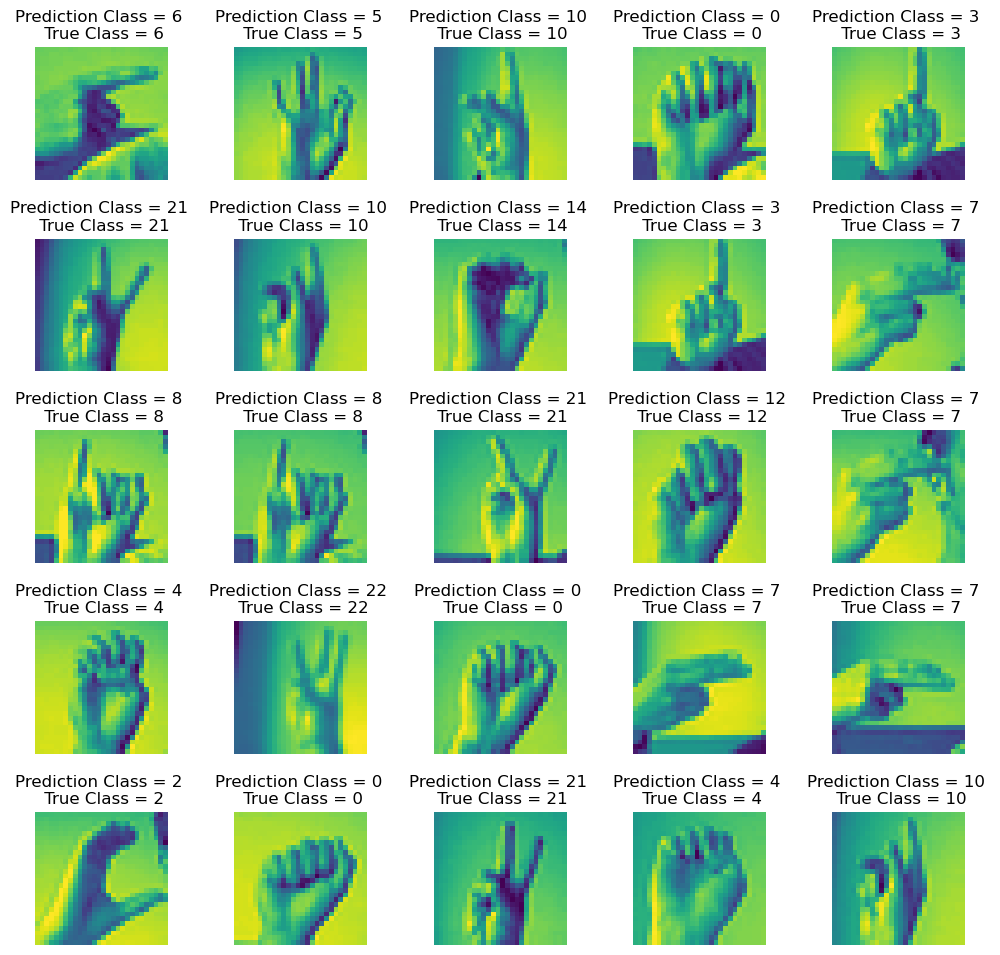

In [365]:
fig, axes = plt.subplots(5, 5, figsize = (12,12)) 
axes = axes.ravel() 
for i in np.arange (0, 5*5):
    if (predicted_classes[i] >= 9):
        axes[i].imshow(xTest[i].reshape(28,28)) 
        axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(pred2[i], yTest2[i])) 
        axes[i].axis('off') 
    else:
        axes[i].imshow(xTest[i].reshape(28,28)) 
        axes[i].set_title("Prediction Class = {0} \n True Class = {1}".format(pred2[i], yTest2[i])) 
        axes[i].axis('off') 
plt.subplots_adjust(wspace = 0.5)

##### Visualização do relatório completo de classificação, usando matrizes de confusão normalizadas e não nor

In [366]:
# A matriz de confusão precisa de rótulos e previsões como dígitos únicos, não como vetores codificados por um ponto
predicted_classes = model.predict_classes(xTest, batch_size=128, verbose=0)
rounded_labels=np.argmax(yTest, axis=1)
cm = metrics.confusion_matrix(rounded_labels, predicted_classes)

##### Definir a função para o gráfico da matriz de confusão

In [367]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # matriz de confusao
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # visualizacao
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, title=title, ylabel='True label', xlabel='Predicted label')

    # girar os rótulos e definir o alinhamento
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # loop sobre dimensoes de dados e criar anotacoes de texto
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

##### Matriz de confusão não normalizada

Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

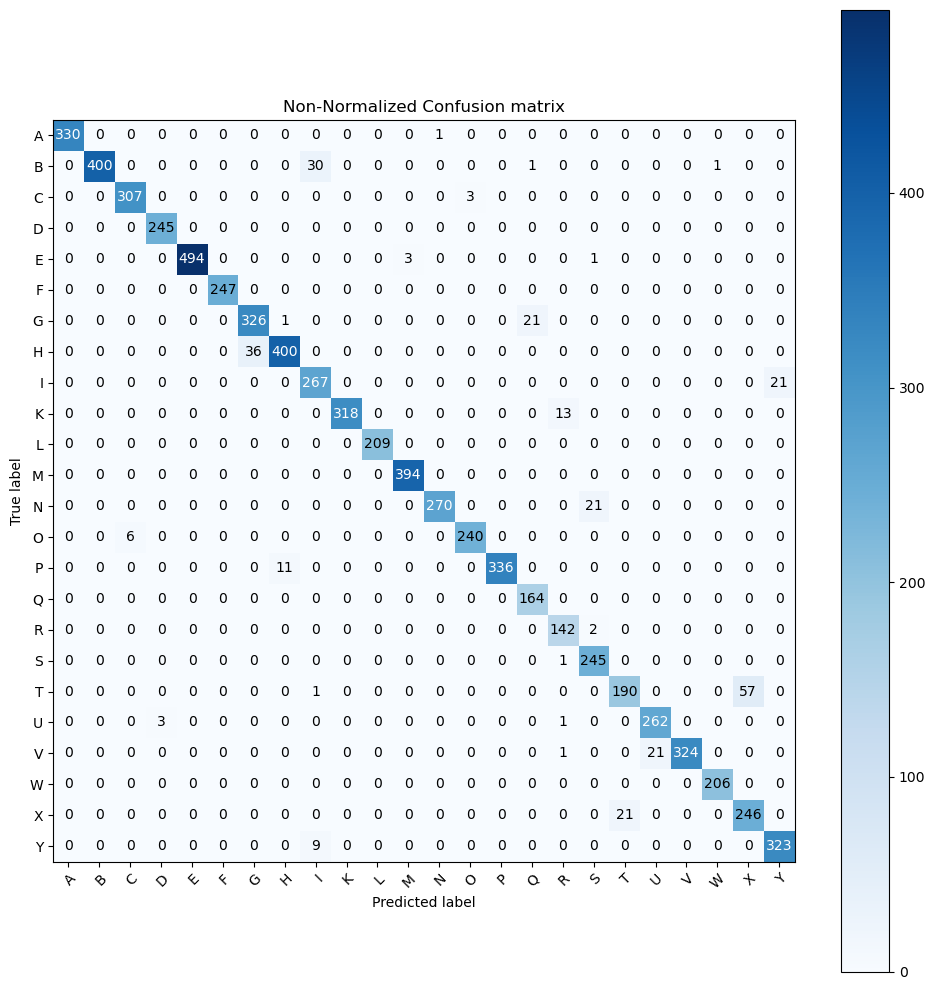

In [368]:
plt.figure(figsize=(20,20))
plot_confusion_matrix(rounded_labels, predicted_classes, classes = class_name, title='Non-Normalized Confusion matrix')
plt.show()

##### Matriz de confusão normalizada

Normalized confusion matrix


<Figure size 3500x3500 with 0 Axes>

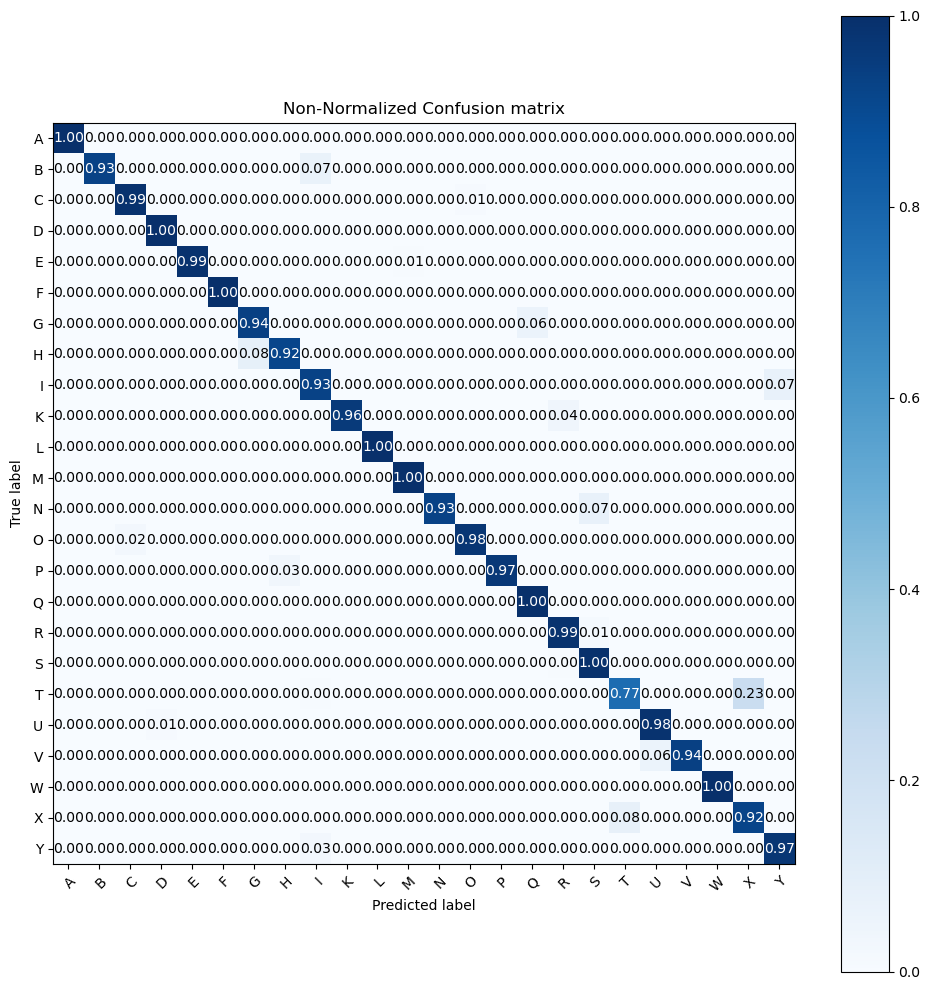

In [369]:
plt.figure(figsize=(35,35))
plot_confusion_matrix(rounded_labels, predicted_classes, classes = class_name, normalize=True, title='Non-Normalized Confusion matrix')
plt.show()

##### Pontuação média de precisão da classificação

In [370]:
from sklearn.metrics import accuracy_score
acc_score = accuracy_score(rounded_labels, predicted_classes)
print('Accuracy Score = ',acc_score)

Accuracy Score =  0.9599832682654769


O modelo treinado obteve uma precisão de cerca de 95,16%. Isso é muito bom. No entanto, é possível obter uma precisão muito maior ajustando os parâmetros que foram usados.

Esta percentagem significa que, para este modelo poder reconhecer corretamente a qual alfabeto um gesto de mão se refere na linguagem de sinais quase 92 vezes para cada 100 imagens! Ou seja, dada uma imagem 28x28 de um gesto de mão como entrada, é altamente provável que nosso modelo identifique o que é corretamente.

Para entender melhor os pontos fortes e fracos desse modelo, criamos uma matriz de confusão.

In [371]:
def classify(image):
    image = cv2.resize(image, (28, 28))
    image = image.astype("float") / 255.0
    image = img_to_array(image)
    image = np.expand_dims(image, axis = 0)
    proba = model.predict(image)
    idx = np.argmax(proba)
    return class_name[idx]

In [372]:
classify(xTrain[2]*255)

'C'

In [373]:
print(yTrain[0])

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [374]:
#RITA, isto é um experimento para provar que se mudarmos alguns pixeis da imagem, a Letra é a mesma,
#mas se mudarmos pixeis a mais a imagem diz que é outra letra.
arr = []
arr = xTrain[0].copy()
arr[0] = 90
arr[1] = 90
#arr[5] = 90

In [375]:
classify(arr*255) # igual a xTrain[0] mas com alterações dos valores do array xTrain[0]

'D'